# Sentiment Analysis for Twitter Tweets
This project performs sentiment analysis by scraping tweets from Twitter and testing for polarity (positive, neutral, and negative) connotation for each Tweet of a query

In [10]:
import snscrape.modules.twitter as sntwitter
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
plt.style.use('fivethirtyeight')

## Scraping Tweets for Analysis
Alternatively we could use ‘Tweepy’ to scrape Tweets but this is limited to about 3,000 tweets and also requires an API authentication process.
However, we have the option to set a limit for the maximum amount of tweets that is scraped

In [11]:
query = "(from:@bongoideas) until:2023-03-13 since:2023-01-01"
tweets = []
limit = 10000

for tweet in sntwitter.TwitterSearchScraper(query).get_items():
    #print(vars(tweet))
    #break 
    if len(tweets) == limit:
        break
    else:
        tweets.append([tweet.date, tweet.user.username, tweet.rawContent])

df = pd.DataFrame(tweets, columns=['Date','User','Tweet'])
#print(vars(tweet))
print(df)

                          Date        User  \
0    2023-03-12 23:51:37+00:00  BongoIdeas   
1    2023-03-12 23:49:36+00:00  BongoIdeas   
2    2023-03-12 21:11:01+00:00  BongoIdeas   
3    2023-03-12 17:19:20+00:00  BongoIdeas   
4    2023-03-12 14:59:43+00:00  BongoIdeas   
...                        ...         ...   
1333 2023-01-01 09:06:44+00:00  BongoIdeas   
1334 2023-01-01 03:08:54+00:00  BongoIdeas   
1335 2023-01-01 03:07:32+00:00  BongoIdeas   
1336 2023-01-01 03:06:01+00:00  BongoIdeas   
1337 2023-01-01 03:00:36+00:00  BongoIdeas   

                                                  Tweet  
0     @wode_maya You make it sound easy but it’s not...  
1     @GhPoliceService Usually, suspects of most cri...  
2     @ypeegh Going outside, taking pictures, and po...  
3     @prett_Ama This is a a very silly yet unintell...  
4                                 @Listo_Mens Good one.  
...                                                 ...  
1333  @sarkodie This year, your mid rap l

 # Processing Scraped Tweets for Analysis
We need to clean the tweets to make it suitable for our models. We do this using the Python package (re)regular expression for filtering strings.
We remove ‘@‘ mentions from tweets, ‘#’ hashtags, and links ‘http’ from Tweets.

In [12]:
# Clean the tweets
def cleanTweet(text):
    text = re.sub(r'@[A-Za-z0-9_]+', '',text) # Removes @ Mentions
    text = re.sub(r'#','', text) # Removing the '#' symbol
    text = re.sub(r'RT[\s]+', '',text)
    text = re.sub(r'https?:\/\/\S+','',text)
    text = re.sub(r'_[A-Za-z0-9]+','',text)
    
    return text

In [13]:
df['Tweet'] = df['Tweet'].apply(cleanTweet)
df

,Date,User,Tweet
0,2023-03-12 23:51:37+00:00,BongoIdeas,"You make it sound easy but it’s not. And yes,..."
1,2023-03-12 23:49:36+00:00,BongoIdeas,"Usually, suspects of most crimes bear Muslim ..."
2,2023-03-12 21:11:01+00:00,BongoIdeas,"Going outside, taking pictures, and posting t..."
3,2023-03-12 17:19:20+00:00,BongoIdeas,This is a a very silly yet unintelligible thi...
4,2023-03-12 14:59:43+00:00,BongoIdeas,Good one.
...,...,...,...
1333,2023-01-01 09:06:44+00:00,BongoIdeas,"This year, your mid rap lines and political h..."
1334,2023-01-01 03:08:54+00:00,BongoIdeas,You can’t be a lover of Mourinho and Sarkodie...
1335,2023-01-01 03:07:32+00:00,BongoIdeas,Let us live to “fulfil” our divine purpose. Y...
1336,2023-01-01 03:06:01+00:00,BongoIdeas,Addo D is most probably going to make things ...


# Using the Pre-Trained roBERTa Model for Sentiment Analysis.
   roBERTa is a pre-trained model for sentiment analysis. It is auto tuned depending on the specific use. For this project we choose the pre-trained model for Twitter

In [14]:
# Define the sentiment analysis model and labels
task = 'sentiment'
roberta = f"cardiffnlp/twitter-roberta-base-{task}"
model = AutoModelForSequenceClassification.from_pretrained(roberta)
tokenizer = AutoTokenizer.from_pretrained(roberta) 
labels = ['Negative','Neutral','Positive']

# Generating Polarities 
We add a new column to our data-frame for Polarity which takes values (positive, neutral, negative)

In [15]:
# Define a list to store the polarities of the tweets
polarities = []

# Loop over each tweet in the dataframe
for tweet in df['Tweet']:
    # Encode the tweet using the tokenizer
    encoded_tweet = tokenizer(tweet, return_tensors='pt')
    
    # Perform sentiment analysis on the encoded tweet using the model
    output = model(**encoded_tweet)
    scores_tweet = output[0][0].detach().numpy()
    scores_tweet = np.exp(scores_tweet) / np.exp(scores_tweet).sum(-1)
    polarity = labels[np.argmax(scores_tweet)]
    
    # Add the polarity to the list of polarities
    polarities.append(polarity)

# Add the list of polarities to the dataframe as a new column
df['Polarity'] = polarities

# Print the dataframe with the new 'Polarity' column
print(df)

                          Date        User  \
0    2023-03-12 23:51:37+00:00  BongoIdeas   
1    2023-03-12 23:49:36+00:00  BongoIdeas   
2    2023-03-12 21:11:01+00:00  BongoIdeas   
3    2023-03-12 17:19:20+00:00  BongoIdeas   
4    2023-03-12 14:59:43+00:00  BongoIdeas   
...                        ...         ...   
1333 2023-01-01 09:06:44+00:00  BongoIdeas   
1334 2023-01-01 03:08:54+00:00  BongoIdeas   
1335 2023-01-01 03:07:32+00:00  BongoIdeas   
1336 2023-01-01 03:06:01+00:00  BongoIdeas   
1337 2023-01-01 03:00:36+00:00  BongoIdeas   

                                                  Tweet  Polarity  
0      You make it sound easy but it’s not. And yes,...  Negative  
1      Usually, suspects of most crimes bear Muslim ...  Negative  
2      Going outside, taking pictures, and posting t...  Negative  
3      This is a a very silly yet unintelligible thi...  Negative  
4                                             Good one.  Positive  
...                                    

# Categorization based on Polarity
Checking percentage of positive polarity tweets

In [16]:
# Sorting sentiment analysis
positive_count = (df['Polarity'] == 'Positive').sum()
print(positive_count)
percentage = positive_count/df.shape[0]
print("Percentage of Positive count is {:.2f}%".format(percentage*100))

247
Percentage of Positive count is 18.46%


Checking percentage of neutral polarity tweets

In [17]:
# Sorting sentiment analysis
neutral_count = (df['Polarity'] == 'Neutral').sum()
print(neutral_count)
percentage = neutral_count/df.shape[0]
print("Percentage of Neutral count is {:.2f}%".format(percentage*100))

556
Percentage of Neutral count is 41.55%


Checking percentage of negative polarity tweets

In [18]:
# Sorting sentiment analysis
negative_count = (df['Polarity'] == 'Negative').sum()
print(negative_count)
percentage = negative_count/df.shape[0]
print("Percentage of Negative count is {:.2f}%".format(percentage*100))

535
Percentage of Negative count is 39.99%


### Data Frame with Polarity Column

In [19]:
df_positive = df.loc[(df['Polarity'] == 'Positive')].copy()
df_positive

,Date,User,Tweet,Polarity
4,2023-03-12 14:59:43+00:00,BongoIdeas,Good one.,Positive
7,2023-03-12 14:15:05+00:00,BongoIdeas,This is actually an opportunity for you to re...,Positive
8,2023-03-12 14:12:31+00:00,BongoIdeas,"Use promo code ""BongoIdeas"" on 1xbet and win a...",Positive
13,2023-03-12 13:06:11+00:00,BongoIdeas,Easy win.,Positive
14,2023-03-12 12:55:44+00:00,BongoIdeas,You need good ambassadors to preserve the MoM...,Positive
...,...,...,...,...
1308,2023-01-03 00:56:07+00:00,BongoIdeas,“Na MoMo no wo se line b3n?” Happy birthday t...,Positive
1311,2023-01-01 13:51:46+00:00,BongoIdeas,Send it. God will bless you abundantly. 😝,Positive
1314,2023-01-01 13:48:05+00:00,BongoIdeas,I would be glad.,Positive
1323,2023-01-01 13:23:39+00:00,BongoIdeas,"If you want to win big in 2023, join my telegr...",Positive


In [20]:
df_neutral = df.loc[(df['Polarity'] == 'Neutral')].copy()
df_neutral

,Date,User,Tweet,Polarity
5,2023-03-12 14:49:50+00:00,BongoIdeas,Who asked???,Neutral
12,2023-03-12 14:00:51+00:00,BongoIdeas,Why do you maintain a neatly trimmed hairstyl...,Neutral
16,2023-03-12 11:59:52+00:00,BongoIdeas,Sex is actually overrated. Sweeter things lik...,Neutral
18,2023-03-12 11:57:40+00:00,BongoIdeas,For where?,Neutral
21,2023-03-12 11:55:06+00:00,BongoIdeas,"As a guy, take this advice from me, no girl i...",Neutral
...,...,...,...,...
1322,2023-01-01 13:34:14+00:00,BongoIdeas,The belief that your pastor receives you mone...,Neutral
1333,2023-01-01 09:06:44+00:00,BongoIdeas,"This year, your mid rap lines and political h...",Neutral
1334,2023-01-01 03:08:54+00:00,BongoIdeas,You can’t be a lover of Mourinho and Sarkodie...,Neutral
1335,2023-01-01 03:07:32+00:00,BongoIdeas,Let us live to “fulfil” our divine purpose. Y...,Neutral


In [21]:
df_negative = df.loc[(df['Polarity'] == 'Negative')].copy()
df_negative

,Date,User,Tweet,Polarity
0,2023-03-12 23:51:37+00:00,BongoIdeas,"You make it sound easy but it’s not. And yes,...",Negative
1,2023-03-12 23:49:36+00:00,BongoIdeas,"Usually, suspects of most crimes bear Muslim ...",Negative
2,2023-03-12 21:11:01+00:00,BongoIdeas,"Going outside, taking pictures, and posting t...",Negative
3,2023-03-12 17:19:20+00:00,BongoIdeas,This is a a very silly yet unintelligible thi...,Negative
6,2023-03-12 14:47:40+00:00,BongoIdeas,So so unfair. How is that a red card? Y’all j...,Negative
...,...,...,...,...
1329,2023-01-01 09:25:01+00:00,BongoIdeas,Deep-throating voice ain’t fit for music \n\n,Negative
1330,2023-01-01 09:25:00+00:00,BongoIdeas,Anybody who listens to Efia Odo’s new track fo...,Negative
1331,2023-01-01 09:12:04+00:00,BongoIdeas,This voice is only fit for shouting out at th...,Negative
1332,2023-01-01 09:08:13+00:00,BongoIdeas,Nobody cares bruh.,Negative


## Generating Top Words with Word Cloud
With WordCloud we can generate an image of the top words used in the entire collection of tweets in the data frame. Using the ‘stopword’ parameter we can filter for common words to give space for more meaningful words to be used in the image.

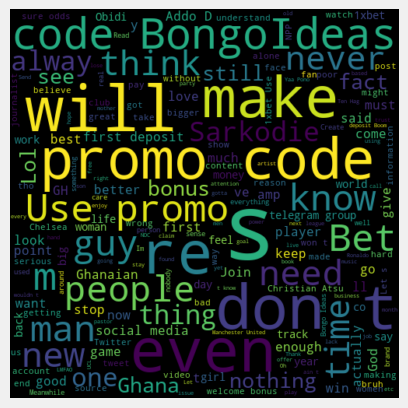

In [22]:
# Creating a word cloud
allWords = ' '.join([twts for twts in df['Tweet']])

wordCloud = WordCloud(width=500,height=500,random_state=21,max_font_size=119,stopwords=STOPWORDS).generate(allWords)
plt.imshow(wordCloud, interpolation = "bilinear")
plt.axis('off')
plt.show()

### Generating word cloud for only Positive Polarity Tweets

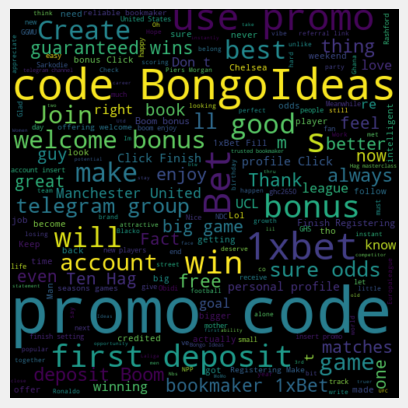

In [23]:
# Creating a word cloud
allWords = ' '.join([twts for twts in df_positive['Tweet']])

wordCloud = WordCloud(width=500,height=500,random_state=21,max_font_size=119,stopwords=STOPWORDS).generate(allWords)
plt.imshow(wordCloud, interpolation = "bilinear")
plt.axis('off')
plt.show()

 ## Generating word cloud for only Neutral Polarity Tweets

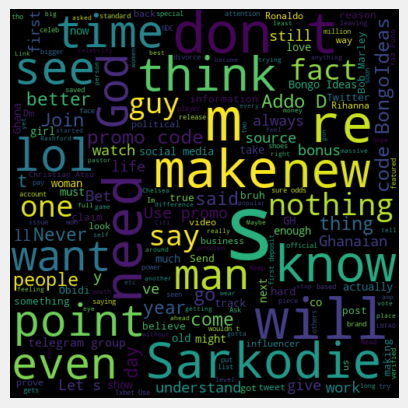

In [24]:
# Creating a word cloud
allWords = ' '.join([twts for twts in df_neutral['Tweet']])

wordCloud = WordCloud(width=500,height=500,random_state=21,max_font_size=119,stopwords=STOPWORDS).generate(allWords)
plt.imshow(wordCloud, interpolation = "bilinear")
plt.axis('off')
plt.show()

## Generating word cloud for only Negative Polarity Tweets

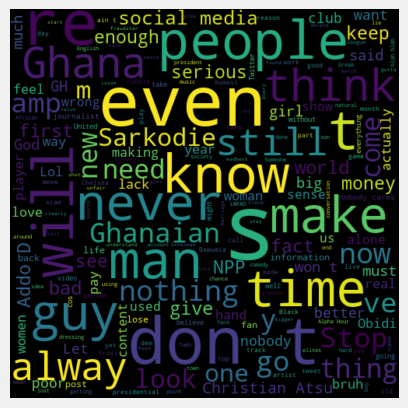

In [25]:
# Creating a word cloud
allWords = ' '.join([twts for twts in df_negative['Tweet']])

wordCloud = WordCloud(width=500,height=500,random_state=21,max_font_size=119,stopwords=STOPWORDS).generate(allWords)
plt.imshow(wordCloud, interpolation = "bilinear")
plt.axis('off')
plt.show()

In [26]:
# Loop over each tweet in the dataframe
for tweet in df['Tweet']:
    # Create a TextBlob object for the tweet
    blob = TextBlob(tweet)
    
    # Perform some basic analysis on the tweet using TextBlob methods
    print('Noun phrases:', blob.noun_phrases)

Noun phrases: ['’ s', 'watch', 'breaking']
Noun phrases: ['muslim', 'islamic']
Noun phrases: ['going', 'cos']
Noun phrases: ['unintelligible thing', 'mad person', 'read']
Noun phrases: []
Noun phrases: ['who']
Noun phrases: ['red card', 'wan frustrate', 'casemiro']
Noun phrases: ['don', '’ t', 'opportunity slide']
Noun phrases: ['promo code', 'bongoideas', 'click', 'fill', 'personal profile', 'сlick “', 'finish registering', 'boom']
Noun phrases: ['herh', 'son ’ s']
Noun phrases: ['sarkodie', 'decent hairstyle', 'shabby ‘', 'shatta wale-like', '’ hairstyle']
Noun phrases: ['dawg', '’ s', 'cut', 'fluffy stuff']
Noun phrases: ['shatta', 'wale ’ s']
Noun phrases: ['easy']
Noun phrases: ['good ambassadors', 'momo', 'hire']
Noun phrases: ['delete', 'wan na']
Noun phrases: ['sex', 'sweeter', 'jackpot hits']
Noun phrases: []
Noun phrases: []
Noun phrases: ['lie']
Noun phrases: ['lol', 'guys', '’ re']
Noun phrases: []
Noun phrases: ['don ’ t', 'don ’ t slack']
Noun phrases: []
Noun phrases: ['

Noun phrases: ['manchester', 'don ’ t fret', '’ m', '’ ll', 'thanks ten hag']
Noun phrases: ['social media dea', 'election outcomes', 'elections', 'politically', 'small fish', 'big pond', 'move']
Noun phrases: ['whether', '’ re']
Noun phrases: ['listen', 'dax', '’ s “', 'dear god']
Noun phrases: ['tbvh', 'track sounds', 'lil bit', 'amapiano', 'easy banger']
Noun phrases: []
Noun phrases: ['join', 'telegram group', 'free sure odds']
Noun phrases: ['aj sarpong', 'citi fm', 'tv [', 'list', 'station ]']
Noun phrases: ['’ re']
Noun phrases: ['graphic designer', 'region', 'conceptual photography…']
Noun phrases: ['special thanks']
Noun phrases: []
Noun phrases: ['special guest speaker', 'entrepreneurship', 'blogging edition', 'koforidua technical']
Noun phrases: []
Noun phrases: ['bigtime fraud', 'exclusive info']
Noun phrases: ['’ s', '’ s']
Noun phrases: ['never', 'try', '’ s legit']
Noun phrases: ['fx trader']
Noun phrases: ['twitter', 'don ’ t', '’ ll']
Noun phrases: ['didn ’ t reply', '

Noun phrases: ['yall', 'obvious things']
Noun phrases: ['fact']
Noun phrases: ['’ s', '’ s', '’ s', '’ s']
Noun phrases: ['celebs babies']
Noun phrases: ['’ s', '’ s', 'rihanna', '’ s son']
Noun phrases: ['rihanna', 'rihanna']
Noun phrases: ['im', 'judging…i ’ m']
Noun phrases: ['’ m', '’ m', 'obvious juxtaposition']
Noun phrases: []
Noun phrases: ['fact']
Noun phrases: []
Noun phrases: ['accra', 'africa', '’ s', 'local', 'price hikes', 'high cost', 'places', 'rabat', 'nairobi']
Noun phrases: ['clout-chasing']
Noun phrases: ['europaleague', 'promo code “', 'bongoideas', '% bonus']
Noun phrases: ['baby', 'rihanna', 'lack ” lol']
Noun phrases: ['rihanna', '’ s baby', 'mother tbvh']
Noun phrases: ['’ ve']
Noun phrases: ['america', '’ s']
Noun phrases: ['arsenal']
Noun phrases: ['don', '’ t', 'promo code “', 'bongoideas', 'bonus 👉🏾']
Noun phrases: ['nuggets']
Noun phrases: ['prioritise']
Noun phrases: ['fact', 'right choices']
Noun phrases: ['’ ve', 'your', 'keep']
Noun phrases: ['release'

Noun phrases: ['say no', 'drugs ”', 'efya', 'efya']
Noun phrases: ['who', 'efya']
Noun phrases: ['manchester', 'sir alex', 'erik', 'hag']
Noun phrases: ['sports events', 'dstv']
Noun phrases: ['sports events']
Noun phrases: ['dstv']
Noun phrases: ['sports events', 'mediocre service']
Noun phrases: []
Noun phrases: ['kindly', 'bawumia', 'past years']
Noun phrases: ['trusting bawumia', 'stripper suggests']
Noun phrases: ['vice president', 'bawumia', 'zero']
Noun phrases: ['physical']
Noun phrases: ['overrated', 'too']
Noun phrases: []
Noun phrases: ['jus', 'promo code “', 'bongoideas', '” 👉🏾']
Noun phrases: ['a-list', 'kwadaso wizkid']
Noun phrases: ['afia schwarzenegger', 'social media', 'shatta wale']
Noun phrases: ['reggae', 'stonebwoy']
Noun phrases: ['big games', 'bookmaker 1xbet', '% bonus', 'ghs', 'new players', 'promo code “', 'bongoideas', '” 👉🏾']
Noun phrases: ['reactionary folk don ’ t', 'basic grammar', '’ t decipher', 'basic hypothetical statements', 'well', "ca n't", 'keep'

Noun phrases: ['chelsea', '’ re', 'mediocre club', 'hope', '’ re']
Noun phrases: ['’ re', 'ghana', '’ ve']
Noun phrases: ['dr likee', 'sexual prowess', 'delay', 'amerado', 'monkey']
Noun phrases: ['begging']
Noun phrases: ['manchesterderby', 'bookmaker 1xbet', 'promo code “', 'bongoideas']
Noun phrases: ['instagram']
Noun phrases: ['bongo ideas', 'instagram', 'dime…solid brand', 'hahahahahahaha']
Noun phrases: ['chelsea', 'utd', 'real madrid', 'liverpool', 'terrible taste']
Noun phrases: ['potter', 'never']
Noun phrases: ['sammy gyamfi', 'jm']
Noun phrases: ['abeg', 'fetch engagement', 'adey', 'search money']
Noun phrases: ['hot tho tbh']
Noun phrases: ['google rate', 'painful reality', 'bog', 'wan na']
Noun phrases: ['create', 'promo code “', 'bongoideas', '” 👉🏾']
Noun phrases: ['addo d', '’ s mid performance', 'ghanaians']
Noun phrases: ['chiana shs', 'girls need', 'addo d', 'free shs']
Noun phrases: ['stop', '’ s backwardness', 'poor people', 'social media']
Noun phrases: ['lol', 'w

## Extracting Noun Phrases from Tweets 
This extracts the relevant subject matter in each tweet.

In [27]:
# Loop over each tweet in the dataframe
for tweet in df_positive['Tweet']:
    # Create a TextBlob object for the tweet
    blob = TextBlob(tweet)
    
    # Perform some basic analysis on the tweet using TextBlob methods
    print('Noun phrases:', blob.noun_phrases)

Noun phrases: []
Noun phrases: ['don', '’ t', 'opportunity slide']
Noun phrases: ['promo code', 'bongoideas', 'click', 'fill', 'personal profile', 'сlick “', 'finish registering', 'boom']
Noun phrases: ['easy']
Noun phrases: ['good ambassadors', 'momo', 'hire']
Noun phrases: ['ucl', 'laliga', '% bonus', 'promo code “', 'bongoideas', 'create', 'insert promo code “', 'bongoideas', 'finish setting']
Noun phrases: ['truer words']
Noun phrases: ['premierleague', 'ufc', '% bonus', 'promo code “', 'bongoideas', 'create', 'insert promo code “', 'bongoideas', 'finish setting']
Noun phrases: ['lil bit', 'pogba', 'hurts']
Noun phrases: ['piers morgan', 'role model']
Noun phrases: ['world atm']
Noun phrases: ['ten hag', 'strong statement', 'perfect man', 'wan bissaka']
Noun phrases: ['horse']
Noun phrases: ['laliga', '% bonus', 'promo code “', 'bongoideas', 'create', 'insert promo code “', 'bongoideas', 'finish setting']
Noun phrases: ['’ re', 'natural ability', 'people laugh', 'uncle akrobeto']
N

In [28]:
# Loop over each tweet in the dataframe
for tweet in df_neutral['Tweet']:
    # Create a TextBlob object for the tweet
    blob = TextBlob(tweet)
    
    # Perform some basic analysis on the tweet using TextBlob methods
    print('Noun phrases:', blob.noun_phrases)

Noun phrases: ['who']
Noun phrases: ['shatta', 'wale ’ s']
Noun phrases: ['sex', 'sweeter', 'jackpot hits']
Noun phrases: []
Noun phrases: []
Noun phrases: []
Noun phrases: []
Noun phrases: ['focus', 'self-image etc', 'love', 'shouldn ’ t']
Noun phrases: ['wayward sons']
Noun phrases: ['fact']
Noun phrases: ['’ s']
Noun phrases: ['fiifi anaman', 'bongo ideas', 'huge vacuum', 'stale profession', 'keep']
Noun phrases: ['power struggle', '’ s']
Noun phrases: []
Noun phrases: ['’ m']
Noun phrases: []
Noun phrases: ['kwesi arthur', 'roddy ricch', 'buh hmmmmm']
Noun phrases: ['explain']
Noun phrases: []
Noun phrases: []
Noun phrases: []
Noun phrases: ['sarkodie', 'german lower-tier pub', 'lmfao']
Noun phrases: ['pain', '” track chronicles', '“ booooshit ” situation', 'kwesi arthur']
Noun phrases: ['ta dawg', 'big homies', 'ground chale ”', 'bongo']
Noun phrases: ['who', '’ s', '’ s']
Noun phrases: []
Noun phrases: []
Noun phrases: ['exactly']
Noun phrases: ['’ s', 'portuguese magnifico']
Nou

Noun phrases: ['wakaso']
Noun phrases: ['’ s', 'mixed']
Noun phrases: ['’ m']
Noun phrases: ['news sources', 'have']
Noun phrases: ['don', '’ t', '’ re', 'right sources']
Noun phrases: ['’ s']
Noun phrases: []
Noun phrases: ['gh', 'wait', 'official sources', 'thank']
Noun phrases: []
Noun phrases: []
Noun phrases: ['doesn ’ t']
Noun phrases: ['block', '’ s', 'one bongo ideas']
Noun phrases: ['hahaha', '’ s', '’ s', 'y ’', 'guys voices']
Noun phrases: ['thought addo d', '’ s']
Noun phrases: []
Noun phrases: ['south…that ’ s', 'whole point', 'ain', '’ t']
Noun phrases: ['god']
Noun phrases: ['’ s', 'bongo ideas']
Noun phrases: ['’ m', 'probable outcome']
Noun phrases: ['’ m', '’ m', 'probable outcomes']
Noun phrases: ['god', '’ s plan']
Noun phrases: ['atsu']
Noun phrases: ['nana aba anamoah', '’ s', 'girls prefect', 'lmfao']
Noun phrases: ['n ur', 'entire tribesmen', 'accra', '’ s']
Noun phrases: ['thought', 'kingdom 😂 😂 😂']
Noun phrases: []
Noun phrases: []
Noun phrases: []
Noun phrase

In [29]:
# Loop over each tweet in the dataframe
for tweet in df_negative['Tweet']:
    # Create a TextBlob object for the tweet
    blob = TextBlob(tweet)
    
    # Perform some basic analysis on the tweet using TextBlob methods
    print('Noun phrases:', blob.noun_phrases)

Noun phrases: ['’ s', 'watch', 'breaking']
Noun phrases: ['muslim', 'islamic']
Noun phrases: ['going', 'cos']
Noun phrases: ['unintelligible thing', 'mad person', 'read']
Noun phrases: ['red card', 'wan frustrate', 'casemiro']
Noun phrases: ['herh', 'son ’ s']
Noun phrases: ['sarkodie', 'decent hairstyle', 'shabby ‘', 'shatta wale-like', '’ hairstyle']
Noun phrases: ['dawg', '’ s', 'cut', 'fluffy stuff']
Noun phrases: ['delete', 'wan na']
Noun phrases: []
Noun phrases: ['lie']
Noun phrases: ['lol', 'guys', '’ re']
Noun phrases: ['don ’ t', 'don ’ t slack']
Noun phrases: ['don', '’ t']
Noun phrases: ['natural sexual', '’ t', '’ ve', 'keep']
Noun phrases: ['’ s', 'wan na entrust', 'dey']
Noun phrases: ['don ’ t', 'your']
Noun phrases: ['samson']
Noun phrases: ['oh', 'anor', 'fi hurt']
Noun phrases: ['john dumelo', 'buh', '’ s power play']
Noun phrases: ['bros']
Noun phrases: ['’ m', '’ t', '’ t']
Noun phrases: []
Noun phrases: ['twitter', '’ s', 'avoid', 'such content']
Noun phrases: ['e

Noun phrases: ['ta pay']
Noun phrases: ['wogyimi']
Noun phrases: ['im']
Noun phrases: ['bbc']
Noun phrases: ['twitter', 'social media platforms', 'real life', '’ s abstract', 'nfts', 'social media', '’ re', 'time bomb']
Noun phrases: []
Noun phrases: ['’ re']
Noun phrases: ['english', '’ re']
Noun phrases: ['atsu', 'god']
Noun phrases: ['lol']
Noun phrases: ['yep', 'god', 'religion tho']
Noun phrases: ['way religion', 'god']
Noun phrases: ['’ s']
Noun phrases: ['religion', 'live', '’ re']
Noun phrases: ['oh', 'alpha hour', 'prayers couldn ’ t', 'atsu', 'does', 'god']
Noun phrases: ['’ t']
Noun phrases: ['chelsea', 'don ’ t rate']
Noun phrases: ['chelsea', 'match t', 'manchester']
Noun phrases: ['complicates things', '’ s', 'good player', 'easy decisions']
Noun phrases: ['avoid entitled women', 'repeat', 'avoid entitled parasitic women']
Noun phrases: ['’ t', 'telegram', 'twitter']
Noun phrases: ['clout-chaser']
Noun phrases: ['ghanaian']
Noun phrases: ['saddick adams', 'atsu', 'now']
N

Noun phrases: ['reggae', 'stonebwoy']
Noun phrases: ['reactionary folk don ’ t', 'basic grammar', '’ t decipher', 'basic hypothetical statements', 'well', "ca n't", 'keep']
Noun phrases: ['won', '’ t', '’ t', 'premier league']
Noun phrases: ['efia ofo', 'bad biitch']
Noun phrases: ['’ s kind', 'young guy', 'natural incident']
Noun phrases: ['oh', 'your', '’ s', 'naaahh', 'sorry']
Noun phrases: ['irrelevant information']
Noun phrases: ['’ t', '’ m']
Noun phrases: ['twitter']
Noun phrases: ['y ’', 'thought', 'y ’', 'don ’ t care', 'bongo', 'cry']
Noun phrases: ['’ re', 'cut']
Noun phrases: ['twitter', 'different world bro']
Noun phrases: ['kwadwo sheldon', 'comical emotional', 'omgvoice', '’ ll']
Noun phrases: ['kwaw kese', 'sarkodie', 'obidi', '’ s career blah blah blah']
Noun phrases: ['gh¢1m', 'momo']
Noun phrases: ['scrappy music career']
Noun phrases: ['’ re', 'shouldn ’ t', '’ t', 'don ’ t']
Noun phrases: ['samini']
Noun phrases: ['’ s weird', 'men boyfriends']
Noun phrases: ['’ s'

## Ranking Noun Phrases by Frequency Count

In [30]:
# Define an empty dictionary to store the noun phrase counts
np_counts = {}

# Loop over each tweet in the dataframe
for tweet in df['Tweet']:
    # Create a TextBlob object for the tweet
    blob = TextBlob(tweet)
    
    # Get the noun phrases for the tweet and update the counts in the dictionary
    for np in blob.noun_phrases:
        if np in np_counts:
            np_counts[np] += 1
        else:
            np_counts[np] = 1

# Sort the dictionary by the counts in descending order
ranked_dict = sorted(np_counts.items(), key=lambda x: x[1], reverse=True)

# Print out the noun phrases and their counts
for np, count in ranked_dict:
    if count > 1:
        print(f"{np} repeats {count} times")

’ s repeats 180 times
bongoideas repeats 67 times
’ re repeats 66 times
’ t repeats 56 times
promo code “ repeats 50 times
’ m repeats 48 times
sarkodie repeats 37 times
don ’ t repeats 37 times
’ ve repeats 30 times
ghana repeats 29 times
god repeats 26 times
% bonus repeats 25 times
join repeats 25 times
’ ll repeats 25 times
don repeats 24 times
your repeats 24 times
addo d repeats 23 times
telegram group repeats 21 times
lol repeats 20 times
obidi repeats 20 times
atsu repeats 20 times
” 👉🏾 repeats 20 times
npp repeats 18 times
chelsea repeats 16 times
ghanaians repeats 16 times
create repeats 15 times
social media repeats 14 times
manchester repeats 13 times
who repeats 12 times
twitter repeats 12 times
y ’ repeats 12 times
sure odds repeats 12 times
im repeats 12 times
keep repeats 11 times
fact repeats 11 times
bongo ideas repeats 11 times
gh repeats 11 times
ronaldo repeats 11 times
lmfao repeats 10 times
never repeats 10 times
stop repeats 10 times
kumasi repeats 9 times
tueh 